# Reverse SentenceTransformer

Given a semantic embedding vector, how can we find a sentence that will give us a similar vector when we run it through a SentenceTransformer? Here we propose an approach based on evolutionary programming.

* initial population: start with a set of nearest neighbors from a database.
* fitness: run the population of sentences and score them by cosine similarity to the target
* mutation and recombination: call GPT3 API
  - sample with a bias toward fitness, and give GPT this sample in a prompt
  - ask GPT to write some similar sentences, specifying recombination and mutation rules
  - always keep some number of the best sentences so far
* rinse and repeat


One use case is to find the sentence (or passage of text) whose embedding vector is most similar to the coefficient vector of a logistic regression classifier. This may help to explain what the classifier identifies. A related application is to find the simplest sentence to represent the centroid of a cluster (explaining the theme of the cluster).

Possible prompts:

    Please write a new paragraph that combines ideas from the two paragraphs given below. Alter the wording a little bit. The new paragraph should be approximately the same length as each of the original paragraphs.

===

    Please write two new paragraphs that collectively capture many of the same ideas in the two paragraphs provided below. Combine parts of the two original paragraphs to make the new ones. You can reword things and occasionally add a few new ideas, but mostly try to stick to concepts similar to those in the paragraphs provided. Format the results as plain text with one paragraph per line.

===

    Please write a set of new paragraphs that collectively capture many of the same ideas in the set of paragraphs provided below. Feel free to copy parts of the provided paragraphs, and to combine parts of different paragraphs to make new ones. You can reword things and occasionally add a few new ideas, but mostly try to stick to similar concepts to those in the paragraphs provided. Please format the results with one paragraph per line.


## Deep Thoughts:
* Do we need to recombine/mutate pairs of sentences, or can GPT deal with larger batches? 
* Should fitness incorporate things other than  cosine similarity to the target? For example, maybe fitness should be biased toward shorter paragraphs.
* Mate selection could encourage diversity; for example, pick the first paragraph by pure fitness, but the second one could be selected to some degree for having a low BLEU score (or differences at the embedding level) compared to the first.
* Do we need to code all of this, or can we just make suggestions in the prompt? Might this be an example where we can usefully combine coding and logic with prompting? We could compare how well different approaches work in practice by comparing how quickly fitness evolves over generations.
* Can we do meta-evolution to select for the prompt that gives us the best/fastest convergence on average?
* Could we use a small (local) language model to recombine and mutate sentences? This might be a good specialized task to demo customized small language models.
* ___The more interesting question is whether we can evolve better prompts___, including both the wording and the example selection. This requires automated evaluation for scoring fitness.


In [1]:
# C:/Users/rmhorton/Documents/phactMI/phactMI_archive/member_companies/openAI_data_cleanup.ipynb

import pandas as pd
import numpy as np
import os
from credentials import key
import openai
from sentence_transformers import SentenceTransformer

ST_MODEL = 'all-mpnet-base-v2'
sentxformer = SentenceTransformer(ST_MODEL)

data_file = "pmid_paragraph_embeddings_all-mpnet-base-v2_float32_bucket0000.parquet"
model_data_file = "PMD_logistic_regression_model_data.parquet"

data_df = pd.read_parquet(data_file)

model_data = pd.read_parquet(model_data_file)
TARGET_VECTOR = model_data[ model_data['pattern_name'] == 'TITLE' ]['coef_unit_vector'][0]


def get_exponentially_decreasing_probabilities(N=30, pow=0.95):
    # N: the length of the desired vector of probabilities
    # pow: controls how sharply the values drop off.
    x = np.array([i+1 for i in range(0, N)])
    y = 1/((x)**pow)
    return y/sum(y)

POPULATION_SIZE = 200

P = get_exponentially_decreasing_probabilities(N=POPULATION_SIZE, pow=0.75) # rank-based probability that a given individual will be chosen to reproduce

client = openai.OpenAI(api_key=key)
print('openai version:', openai.__version__)

def generate_similar_sentences(example_list, num_examples_to_generate=10):
    # Not guaranteed to return the specified number of examples!!!
    import re
    number_pat = r"^\d[.:]? +"
    example_text = '\n'.join(example_list)
    user_content = f"Make a set of {num_examples_to_generate} fictitious article titles that each combine ideas from at least two of the following examples: \n===\n{example_text}"
    # print(user_content)
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Your job is to generate text data. Please return the text as a numbered list."},
        {"role": "user", "content": user_content}
      ]
    )

    if completion.choices[0].finish_reason != 'stop':
        raise Exception("Bad finish reason: " + completion.choices[0].finish_reason)
    else:
        return [re.sub(number_pat, '', example) for example in completion.choices[0].message.content.split("\n") if re.match(number_pat, example)]


def score_and_sort_by_fitness(df, target_vector=TARGET_VECTOR, vector_col='vector'):
    vector_array = np.array([v for v in df[vector_col]])
    df['score'] = np.dot(vector_array, target_vector).tolist()
    df = df.sort_values('score', ascending=False)
    return df


def get_next_generation(population):
    new_text = list(population['text'][0:5])
    while len(new_text) < POPULATION_SIZE:
        # pick parents
        parent_indexes = np.random.choice(list(range(POPULATION_SIZE)), 2, replace=False, p=P)
        parents = population.iloc[parent_indexes]
        # add offspring to population
        offspring = generate_similar_sentences(parents['text'], num_examples_to_generate=10)
        new_text.extend(offspring)

    new_text = new_text[0:POPULATION_SIZE]
    
    df = pd.DataFrame({'text': new_text, 'vector': sentxformer.encode(new_text).tolist()})
    return score_and_sort_by_fitness(df)


openai version: 1.14.0


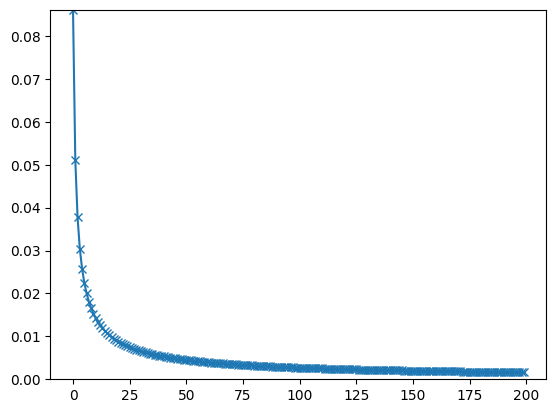

In [2]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set_ylim([0, np.max(P)])
plt.plot(P, marker='x')

In [3]:
provided_examples = ['I am the walrus.', 
                     'We all live in a yellow submarine.', 
                     'In Penny Lane there is a barber showing photographs.']

# provided_examples = ['The concept of a euclidean distance can be applied in any number of dimensions.', 
#                      'The cosine distance between two unit vectors is the same as their inner product.']

generated_examples = generate_similar_sentences(provided_examples, num_examples_to_generate=15)

print(generated_examples)

['"Living in a Yellow Submarine: Exploring the Secret Life of the Walrus"', '"Barbershop Tales: Photographs Revealing the Underground World of Penny Lane"', '"Unraveling Mysteries: The Enigmatic Walrus of Penny Lane"', '"Submarine Adventures: Following the Walrus to Penny Lane"', '"Yellow Submarine Chronicles: A Glimpse into the Life of the Walrus"', '"Through the Looking Glass: Walrus Encounters in Penny Lane\'s Barber Shop"', '"In the Footsteps of the Walrus: Navigating the Yellow Submarine in Penny Lane"', '"Barber\'s Secrets: The Curious Case of the Walrus in Penny Lane"', '"Submerged in Penny Lane: Captivating Photographs of the Walrus"']


In [4]:
candidates = data_df[data_df['section_path'] == 'Title'][['text', 'vector']]
len(candidates)  # 2190

population = score_and_sort_by_fitness(candidates).head(POPULATION_SIZE)

In [5]:
population

,text,vector,score
34383,Giving radiologists a voice: a review of podca...,"[0.05755859985947609, 0.036836907267570496, -0...",0.023897
45294,ASSOCIATION BETWEEN BODY WEIGHT PERCEPTION AND...,"[0.024106645956635475, 0.052460867911577225, 0...",0.023422
29066,Qualitative evaluation of trauma delays in roa...,"[-0.03067016415297985, 0.01931152679026127, -0...",0.021739
54656,"Income Inequality, Neighbourhood Social Capita...","[-0.029706697911024094, 0.07145822793245316, 0...",0.021057
9302,Decision coaching using the Ottawa family deci...,"[-0.001663097646087408, 0.020671505481004715, ...",0.020394
...,...,...,...
6262,Draft Genome Sequencing of Vibrio cholerae O1 ...,"[0.05102767422795296, -0.009247866459190845, -...",0.011297
14962,Identification of Differentially Expressed Gen...,"[-0.02446342632174492, 0.051581971347332, -0.0...",0.011291
62354,Experimental Study on the Corrosion of Carbon ...,"[0.027739986777305603, -0.022513648495078087, ...",0.011273
39414,No association between proton pump inhibitor u...,"[-0.029004709795117378, 0.006637963932007551, ...",0.011259


In [6]:
# len(population)
# len(P)
# list(range(POPULATION_SIZE))

# parent_indexes = np.random.choice(list(range(POPULATION_SIZE)), 2, replace=False, p=P) # where P is a weight vector
# print(parent_indexes)

# parents = population.iloc[parent_indexes]
# parents

# generate_similar_sentences(parents['text'], num_examples_to_generate=10)

# nextgen = get_next_generation(population).reset_index()
# nextgen.plot.scatter(x='index', y='score')

# nextgen['score'].tolist()[0] # 0.025802107748119266

In [8]:
for generation_number in range(30):
    nextgen = get_next_generation(population).reset_index()
    print("Generation", generation_number, "max score:", nextgen['score'].tolist()[0]) # also print the best title so fat!!!
    nextgen.to_parquet(f"run2_generation_{generation_number:02d}.parquet")
    population = nextgen

Generation 0 max score: 0.030332972341657192
Generation 1 max score: 0.030883695016748328
Generation 2 max score: 0.033700022721826706
Generation 3 max score: 0.03386366352476354
Generation 4 max score: 0.034814459536273545
Generation 5 max score: 0.03550358974426578
Generation 6 max score: 0.03811897180553128
Generation 7 max score: 0.03811897180553128
Generation 8 max score: 0.03811897180553128
Generation 9 max score: 0.03824088677751736
Generation 10 max score: 0.03824088677751733
Generation 11 max score: 0.03824088677751733
Generation 12 max score: 0.03824088677751733
Generation 13 max score: 0.03958716472764309
Generation 14 max score: 0.03958716472764309
Generation 15 max score: 0.040938867491247186
Generation 16 max score: 0.04093886749124722
Generation 17 max score: 0.04093886749124722
Generation 18 max score: 0.04103579227739193
Generation 19 max score: 0.04213692145171493
Generation 20 max score: 0.04389859061203157
Generation 21 max score: 0.044011734859722526
Generation 22 

In [ ]:
population.plot.scatter(x='index', y='score')

In [35]:
history_files = [f for f in os.listdir() if f.startswith("run2_generation")]

generation_list = []
for i in range(len(history_files)):
    hf = history_files[i]
    df = pd.read_parquet(hf)
    df['rank'] = list(range(len(df)))
    df['generation'] = i
    generation_list.append(df)
    print(i, round(df['score'][0], 5), df['text'][0])

0 0.03033 "Podcasting for Change: Improving Adolescent Diet Quality Through Radiology Insights"
1 0.03088 "Podcasting for Change: The Link Between Body Weight Perception and Adolescent Diets"
2 0.0337 The Influence of Podcasting on Teenagers' Body Weight Perception in Urban Areas
3 0.03386 Urban Teenagers' Perception of Body Weight: A Podcasting Perspective
4 0.03481 "Podcasting for Positive Body Image: Urban Teenagers' Perspectives on Diet"
5 0.0355 "Revolutionizing Teen Body Image: The Role of Podcasting in Diet Awareness"
6 0.03812 "Teen Perspectives on Body Image and Diet: The Podcasting Revolution"
7 0.03812 "Teen Perspectives on Body Image and Diet: The Podcasting Revolution"
8 0.03812 "Teen Perspectives on Body Image and Diet: The Podcasting Revolution"
9 0.03824 "Podcasting for Confidence: A Guide to Boosting Teen Self-Esteem"
10 0.03824 "Podcasting for Confidence: A Guide to Boosting Teen Self-Esteem"
11 0.03824 "Podcasting for Confidence: A Guide to Boosting Teen Self-Esteem"

<Axes: xlabel='rank', ylabel='score'>

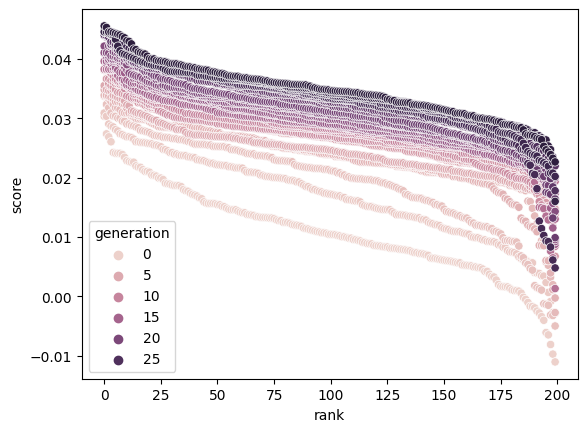

In [36]:
import seaborn as sns

generation_data = pd.concat(generation_list)
sns.scatterplot(generation_data, x='rank', y='score', hue='generation')
                           